In [113]:
pip install simpy

Note: you may need to restart the kernel to use updated packages.


In [115]:
import simpy
import random
import numpy as np

class StatusUpdateSystem:
    def __init__(self, env, service_rate, buffer_size, policy="M/M/1/1"):
        self.env = env
        self.service_rate = service_rate
        self.buffer_size = buffer_size
        self.policy = policy
        self.queue = []
        self.server_busy = False
        self.last_update_time = 0
        self.age_records = []
        self.peak_age_records = []

    def packet_arrival(self, arrival_time):
        if self.server_busy and self.policy == "M/M/1/1":
            return
        elif self.server_busy and len(self.queue) >= self.buffer_size:
            if self.policy == "M/M/1/2*":
                self.queue.pop(0)
            elif self.policy == "M/M/1/2":
                return

        self.queue.append(arrival_time)
        if not self.server_busy:
            self.env.process(self.process_packet())

    def process_packet(self):
        self.server_busy = True
        while self.queue:
            packet_time = self.queue.pop(0)
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            departure_time = self.env.now
            age = departure_time - packet_time
            self.age_records.append(age)
            self.peak_age_records.append(departure_time - self.last_update_time)
            self.last_update_time = departure_time
        self.server_busy = False

def generate_packets(env, arrival_rate, system):
    while True:
        interarrival_time = random.expovariate(arrival_rate)
        yield env.timeout(interarrival_time)
        arrival_time = env.now
        system.packet_arrival(arrival_time)

def simulate_aois_extended(arrival_rate, service_rate, buffer_size, policy, sim_time=1000):
    env = simpy.Environment()
    system = StatusUpdateSystem(env, service_rate, buffer_size, policy)
    env.process(generate_packets(env, arrival_rate, system))
    env.run(until=sim_time)


    avg_age = np.mean(system.age_records)
    var_age = np.var(system.age_records)
    peak_age = np.mean(system.peak_age_records)
    throughput = len(system.age_records) / sim_time  

    
    peak_aois = system.peak_age_records
    peak_aois_summary = {
        "Min Peak AoI": np.min(peak_aois) if peak_aois else 0,
        "Max Peak AoI": np.max(peak_aois) if peak_aois else 0,
        "90th Percentile Peak AoI": np.percentile(peak_aois, 90) if peak_aois else 0,
    }

    return avg_age, var_age, peak_age, throughput, peak_aois_summary


arrival_rate = 0.8  
service_rate = 1.0  
sim_time = 1000     


policies = ["M/M/1/1", "M/M/1/2", "M/M/1/2*"]
buffer_size = {"M/M/1/1": 1, "M/M/1/2": 2, "M/M/1/2*": 2}
results = {}

for policy in policies:
    avg_age, var_age, peak_age, throughput, peak_aois_summary = simulate_aois_extended(
        arrival_rate, service_rate, buffer_size[policy], policy, sim_time
    )
    results[policy] = {
        "Average AoI": avg_age,
        "Variance AoI": var_age,
        "Peak AoI": peak_age,
        "Throughput": throughput,
        **peak_aois_summary
    }


for policy, metrics in results.items():
    print(f"Policy: {policy}")
    print(f"  Average AoI: {metrics['Average AoI']:.4f}")
    print(f"  Variance of AoI: {metrics['Variance AoI']:.4f}")
    print(f"  Peak AoI: {metrics['Peak AoI']:.4f}")
    print(f"  Throughput: {metrics['Throughput']:.4f}")
    print(f"  Min Peak AoI: {metrics['Min Peak AoI']:.4f}")
    print(f"  Max Peak AoI: {metrics['Max Peak AoI']:.4f}")
    print(f"  90th Percentile Peak AoI: {metrics['90th Percentile Peak AoI']:.4f}\n")




Policy: M/M/1/1
  Average AoI: 1.0656
  Variance of AoI: 1.1139
  Peak AoI: 2.3109
  Throughput: 0.4320
  Min Peak AoI: 0.0392
  Max Peak AoI: 10.9447
  90th Percentile Peak AoI: 4.4304

Policy: M/M/1/2
  Average AoI: 1.8552
  Variance of AoI: 2.7159
  Peak AoI: 1.5291
  Throughput: 0.6530
  Min Peak AoI: 0.0018
  Max Peak AoI: 13.4701
  90th Percentile Peak AoI: 3.4014

Policy: M/M/1/2*
  Average AoI: 1.4440
  Variance of AoI: 1.4083
  Peak AoI: 1.4739
  Throughput: 0.6780
  Min Peak AoI: 0.0012
  Max Peak AoI: 12.1914
  90th Percentile Peak AoI: 3.4115



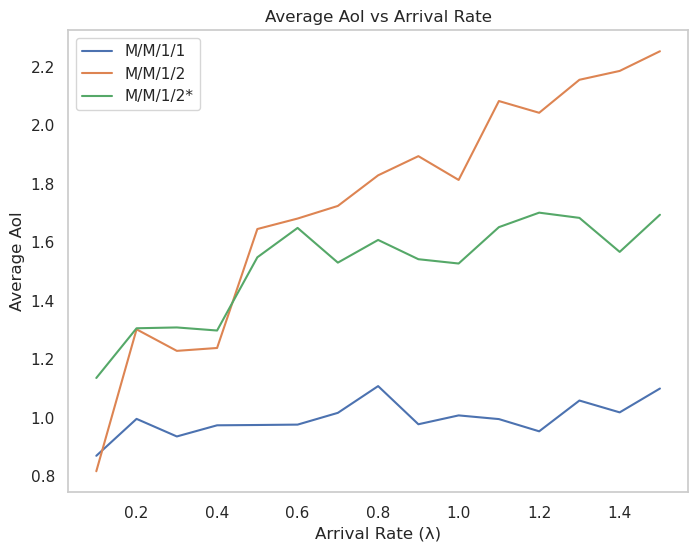

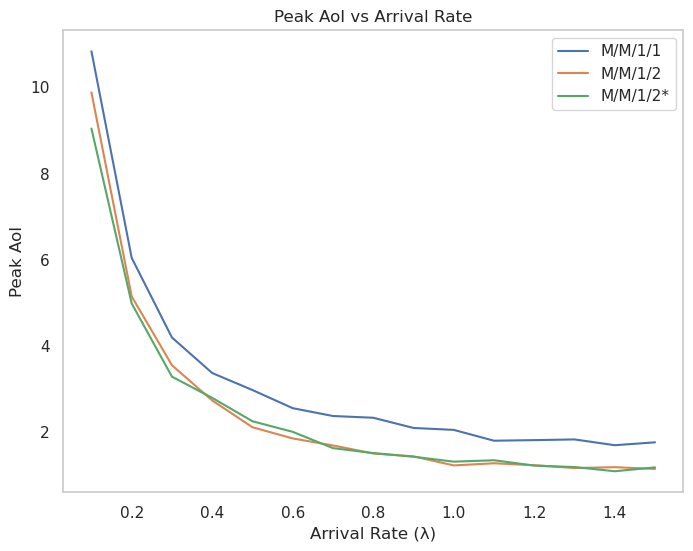

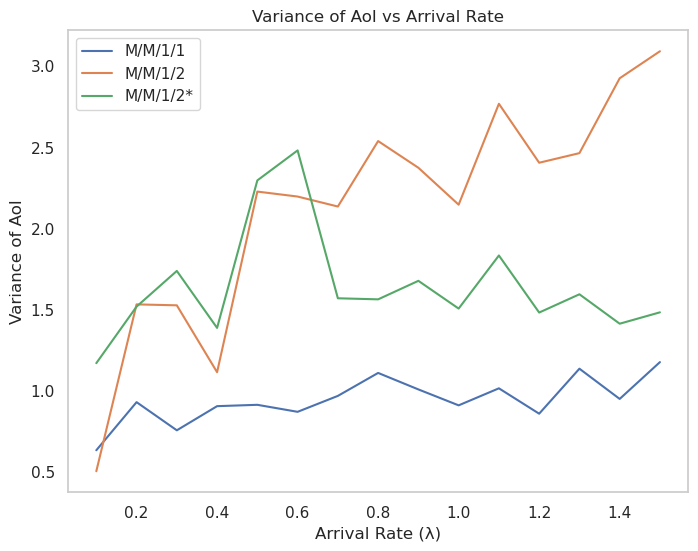

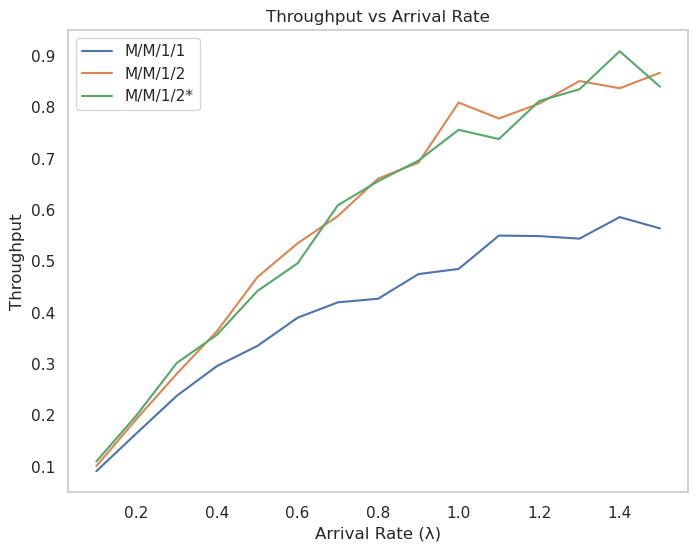

/home/gigluuu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gigluuu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gigluuu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


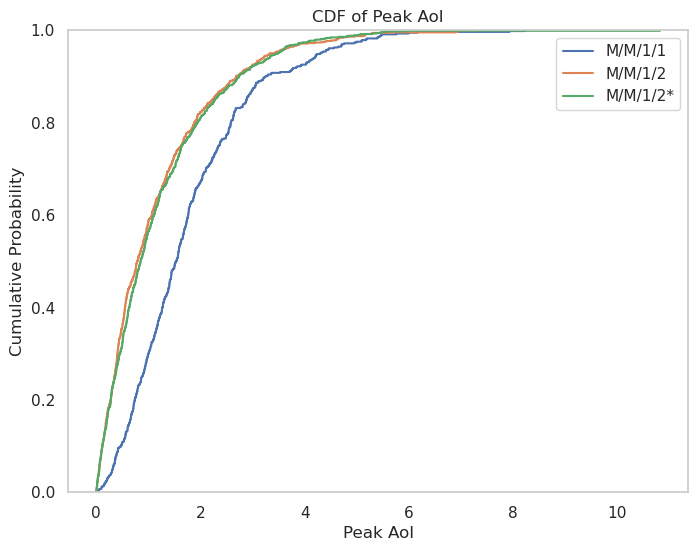

In [116]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

class StatusUpdateSystem:
    def __init__(self, env, service_rate, buffer_size, policy="M/M/1/1"):
        self.env = env
        self.service_rate = service_rate
        self.buffer_size = buffer_size
        self.policy = policy
        self.queue = []
        self.server_busy = False
        self.last_update_time = 0
        self.age_records = []
        self.peak_age_records = []

    def packet_arrival(self, arrival_time):
        if self.server_busy and self.policy == "M/M/1/1":
            return
        elif self.server_busy and len(self.queue) >= self.buffer_size:
            if self.policy == "M/M/1/2*":
                self.queue.pop(0)
            elif self.policy == "M/M/1/2":
                return

        self.queue.append(arrival_time)
        if not self.server_busy:
            self.env.process(self.process_packet())

    def process_packet(self):
        self.server_busy = True
        while self.queue:
            packet_time = self.queue.pop(0)
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            departure_time = self.env.now
            age = departure_time - packet_time
            self.age_records.append(age)
            self.peak_age_records.append(departure_time - self.last_update_time)
            self.last_update_time = departure_time
        self.server_busy = False

def generate_packets(env, arrival_rate, system):
    while True:
        interarrival_time = random.expovariate(arrival_rate)
        yield env.timeout(interarrival_time)
        arrival_time = env.now
        system.packet_arrival(arrival_time)

def simulate_aois_extended(arrival_rate, service_rate, buffer_size, policy, sim_time=1000):
    env = simpy.Environment()
    system = StatusUpdateSystem(env, service_rate, buffer_size, policy)
    env.process(generate_packets(env, arrival_rate, system))
    env.run(until=sim_time)
    
    avg_age = np.mean(system.age_records)
    var_age = np.var(system.age_records)
    peak_age = np.mean(system.peak_age_records)
    throughput = len(system.age_records) / sim_time  
    return avg_age, var_age, peak_age, throughput, system.peak_age_records

policies = ["M/M/1/1", "M/M/1/2", "M/M/1/2*"]
buffer_size = {"M/M/1/1": 1, "M/M/1/2": 2, "M/M/1/2*": 2}
service_rate = 1.0  
sim_time = 1000     
arrival_rates = np.linspace(0.1, 1.5, 15)  

extended_results = {policy: {"Average AoI": [], "Variance AoI": [], "Peak AoI": [], 
                             "Throughput": [], "Peak AoI Data": []} for policy in policies}

for policy in policies:
    for arrival_rate in arrival_rates:
        avg_age, var_age, peak_age, throughput, peak_ages = simulate_aois_extended(
            arrival_rate, service_rate, buffer_size[policy], policy, sim_time)
        extended_results[policy]["Average AoI"].append(avg_age)
        extended_results[policy]["Variance AoI"].append(var_age)
        extended_results[policy]["Peak AoI"].append(peak_age)
        extended_results[policy]["Throughput"].append(throughput)
        if arrival_rate == arrival_rates[-1]:  
            extended_results[policy]["Peak AoI Data"].extend(peak_ages)
            
# Average AoI
plt.figure(figsize=(8, 6))
for policy in policies:
    plt.plot(arrival_rates, extended_results[policy]["Average AoI"], label=policy)
plt.title("Average AoI vs Arrival Rate")
plt.xlabel("Arrival Rate (λ)")
plt.ylabel("Average AoI")
plt.legend()
plt.grid()
plt.show()

# Peak AoI
plt.figure(figsize=(8, 6))
for policy in policies:
    plt.plot(arrival_rates, extended_results[policy]["Peak AoI"], label=policy)
plt.title("Peak AoI vs Arrival Rate")
plt.xlabel("Arrival Rate (λ)")
plt.ylabel("Peak AoI")
plt.legend()
plt.grid()
plt.show()

# Variance of AoI
plt.figure(figsize=(8, 6))
for policy in policies:
    plt.plot(arrival_rates, extended_results[policy]["Variance AoI"], label=policy)
plt.title("Variance of AoI vs Arrival Rate")
plt.xlabel("Arrival Rate (λ)")
plt.ylabel("Variance of AoI")
plt.legend()
plt.grid()
plt.show()

# Throughput
plt.figure(figsize=(8, 6))
for policy in policies:
    plt.plot(arrival_rates, extended_results[policy]["Throughput"], label=policy)
plt.title("Throughput vs Arrival Rate")
plt.xlabel("Arrival Rate (λ)")
plt.ylabel("Throughput")
plt.legend()
plt.grid()
plt.show()

# CDF of Peak AoI
plt.figure(figsize=(8, 6))
for policy in policies:
    sns.ecdfplot(extended_results[policy]["Peak AoI Data"], label=policy)
plt.title("CDF of Peak AoI")
plt.xlabel("Peak AoI")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid()
plt.show()